In [42]:
import pandas as pd
import numpy as np
import subprocess
import os
import glob
from pymatgen.core.periodic_table import Element
import pandas as pd

import numpy as np
import random

import copy

%matplotlib inline
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib 
import matplotlib.pyplot as plt

In [43]:
calctype = "mt"
dpi = 300

In [44]:
class Hea4_3Featuredata:
    def __init__(self,calctype):
        """
        calctype= asa : touching sphere,  mt: overlapped sphere
        """
        if calctype == "asa":
            file_name = "data/asa_M_Tc_cnd.csv"
            df = pd.read_csv(file_name)
            df.drop(columns=["id","id1"], inplace=True)
        elif calctype == "mt":
            file_name = "data/muffintin_M_Tc.csv"
            df = pd.read_csv(file_name)
            df.drop(columns=["id"], inplace=True)
        else:
            print("unknown calctype",calctype)
            raise
    
        self.df_raw = df
        
        del_index = []
        for heakey in df[df["conv"]==False]["heakey"].values:
            del_index.extend(df[df["heakey"]==heakey].index)
        print("index to delete", del_index)
        df2 = df.drop(del_index)
        df = df2
   
        df = df[df["conv"]]
        df["total magnetic moment per volume"] = np.abs(df["total moment"].astype(float)/ df["volume"].astype(float))
            
        polytyp = "bcc"
        df_bcc_conv = df[df["polytyp"]==polytyp]
        
        polytyp = "fcc"
        df_fcc_conv= df[df["polytyp"]==polytyp]
        
        self.df_conv = {"bcc": df_bcc_conv, "fcc": df_fcc_conv}
        
        print("len(bcc)", len(self.df_conv["bcc"]), "hen(fcc)", len(self.df_conv["fcc"]))
        
    def select_columns(self, columns):
        df = {}
        columns2 = {}
        for suffix in ["bcc","fcc"]:
            columns2[suffix] = []
            for name in columns:
                if name == "heakey":
                    columns2[suffix].append(name)
                else:
                    columns2[suffix].append("_".join([name,suffix]))
            df[suffix] = self.df_conv[suffix][columns]
            df[suffix].columns = columns2[suffix]

        df = pd.merge(df["bcc"], df["fcc"], on="heakey")
        df["dTE"] = df["TE(Ry)_bcc"].astype(float) - df["TE(Ry)_fcc"].astype(float)
        idx_fcc = list(df[df["dTE"]>=0].index)
        print("fcc size", len(idx_fcc))
        df_fcc = df.loc[idx_fcc, columns2["fcc"]]
        df_fcc.columns = columns
        idx_bcc = list(df[df["dTE"]<0].index)  
        print("bcc size", len(idx_bcc))
        df_bcc = df.loc[idx_bcc, columns2["bcc"]]
        df_bcc.columns = columns
        
        self.df_stable = pd.concat([df_bcc, df_fcc])
        print("all shape",self.df_stable.shape)

In [45]:
hea = Hea4_3Featuredata(calctype=calctype)

/home/kino/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (12,13,14,15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


index to delete [14954, 14955, 35634, 35635, 103578, 103579, 119432, 119433]
len(bcc) 71948 hen(fcc) 71948


In [46]:
import sys
sys.path.append(".")
from plt_PeriodicTable import plt_PeriodicTable


In [47]:
columns = ["heakey", "total magnetic moment per volume", "TC(K)", "resistivity(micro ohm cm)", "TE(Ry)"]
hea.select_columns(columns)

fcc size 12021
bcc size 59927
all shape (71948, 5)


In [48]:
def make_df(hea):
    df = hea.df_stable
    random.seed(0)
    idx_list = list(df.index)
    random.shuffle(idx_list)
    df = df.iloc[idx_list,:]
    return df

df = make_df(hea)

In [49]:
def make_M_TC_R(df):
    label_list = ['total magnetic moment per volume', "TC(K)", 'resistivity(micro ohm cm)']
    display_label_list = ["$M (\mu_B /\AA^3)$","$T_C (K)$","$R (\mu \Omega cm)$"]
    value_list = []
    for label in label_list:
        value_list.append(df[label].astype(float).values)

    M = df['total magnetic moment per volume'].astype(float).values
    TC = df["TC(K)"].astype(float).values
    R = df['resistivity(micro ohm cm)'].astype(float).values
    heakey = df["heakey"].astype(str).values
    return label_list, display_label_list, value_list, M, TC, R, heakey

label_list, display_label_list, value_list, M, TC, R, heakey = make_M_TC_R(df)

In [50]:
def heakey2zlist(key):
    zlist = []
    for i in range(len(key)//2):
        s = key[i*2:i*2+2]
        zlist.append(int(s))
    return zlist

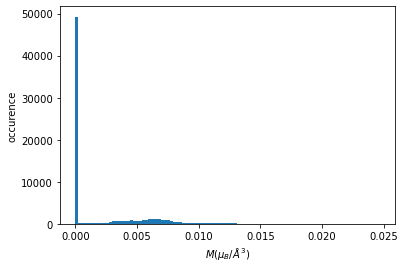

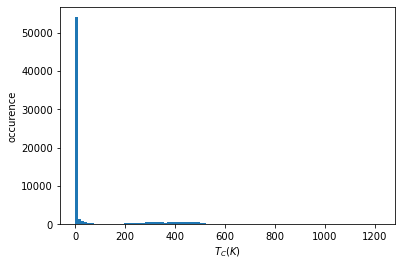

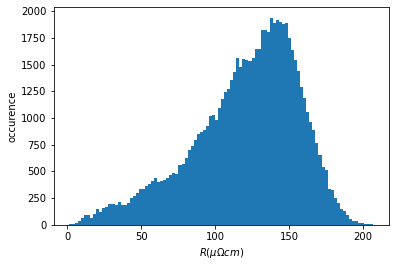

In [51]:
def plot_value_list_hist(value_list, display_label_list):
    for i in range(len(value_list)):
        res = plt.hist(value_list[i], bins=100)
        plt.xlabel(display_label_list[i])
        plt.ylabel("occurence")
        plt.show()
        
plot_value_list_hist(value_list, display_label_list)

In [52]:
fig_dir = "addmaterialsfig3.{}.{}dpi".format(calctype,dpi)
print(fig_dir)
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

addmaterialsfig3.mt.300dpi


In [53]:
showfig = False

if not showfig:
    %matplotlib agg
    %matplotlib agg
else:
    %matplotlib inline

def make_3dfig(value_list, display_label_list, heakey, select_idx, fig_dir = "rotationfig"):

    zlist = heakey2zlist(heakey[select_idx])
    print(zlist)
    
    scaled_values = []
    for values in value_list:
        scaled_values.append(MinMaxScaler().fit_transform(values.reshape(-1,1)))
    zeros = np.zeros(scaled_values[0].shape[0]).reshape(-1,1)

    # not showing figure
    if not showfig:
        matplotlib.use("Agg")

    azim = 30
    print(select_idx, )
    filename = os.path.join(fig_dir, "p{:05d}.png".format(select_idx))
    
    if os.path.isfile(filename):
        return 
        
    fig, ax = plt.subplots(figsize=(3,2), tight_layout=True, dpi=300)
    pctable = plt_PeriodicTable(zlist, font_size=6)    
    pctable.set_table(ax)
    fig.savefig(filename)
    plt.close()
    
    minmax_list = []
    for i in range(3):
        minmax_list.append((value_list[i].min(), value_list[i].max()))
    
    alpha = 0.5
    filename = os.path.join(fig_dir, "r{:05d}.png".format(select_idx))
    fig = plt.figure(figsize=(5,5), tight_layout=True, dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    M_TC_R_color = np.hstack((scaled_values[0], scaled_values[1], scaled_values[2]))
    ax.scatter(value_list[0][:select_idx], value_list[1][:select_idx], value_list[2][:select_idx],
               color=M_TC_R_color[:select_idx], marker=".", alpha=alpha)
    ax.scatter(value_list[0][select_idx], value_list[1][select_idx], value_list[2][select_idx],
               color="red", marker="o")    
    ax.scatter(value_list[0][select_idx], value_list[1][select_idx], value_list[2][select_idx],
               color=M_TC_R_color[select_idx], marker=".")        
    ax.set_xlim(minmax_list[0])
    ax.set_ylim(minmax_list[1])
    ax.set_zlim(minmax_list[2])
    ax.set_xlabel(display_label_list[0])
    ax.set_ylabel(display_label_list[1])
    ax.set_zlabel(display_label_list[2])
    ax.view_init(elev=30, azim = azim)
    fig.savefig(filename)
    plt.close()
 

In [54]:
def make_movie_png(value_list, display_label_list, heakey, fig_dir):
    """
    make png files 
    """
    for select_idx in range(0,30):
        make_3dfig(value_list, display_label_list, heakey, select_idx, fig_dir)

    for select_idx in range(30, 100, 5):
        make_3dfig(value_list, display_label_list, heakey, select_idx, fig_dir)

    for select_idx in range(100, 300, 10):
        make_3dfig(value_list, display_label_list, heakey, select_idx, fig_dir)

    for select_idx in range(300, 10000, 1000):
        make_3dfig(value_list, display_label_list, heakey, select_idx, fig_dir)

    for select_idx in range(10000, 70000, 5000):
        make_3dfig(value_list, display_label_list, heakey, select_idx, fig_dir)

    for select_idx in range(len(heakey)-1, len(heakey), ):
        make_3dfig(value_list, display_label_list, heakey, select_idx, fig_dir)
        
make_movie_png(value_list, display_label_list, heakey, fig_dir)

[13, 46, 49, 72]
0
[24, 78, 79, 80]
1
[41, 47, 49, 82]
2
[23, 39, 44, 72]
3
[42, 43, 79, 82]
4
[27, 76, 79, 80]
5
[26, 42, 45, 81]
6
[46, 48, 72, 75]
7
[13, 21, 24, 30]
8
[32, 41, 43, 80]
9
[21, 31, 45, 50]
10
[23, 25, 72, 78]
11
[42, 75, 76, 83]
12
[30, 47, 76, 81]
13
[22, 48, 74, 81]
14
[14, 26, 32, 45]
15
[26, 32, 72, 77]
16
[39, 41, 49, 74]
17
[21, 39, 48, 50]
18
[72, 73, 75, 80]
19
[29, 32, 39, 48]
20
[32, 40, 47, 81]
21
[22, 29, 77, 81]
22
[43, 49, 75, 79]
23
[32, 44, 74, 76]
24
[74, 78, 80, 82]
25
[22, 26, 30, 74]
26
[27, 40, 79, 83]
27
[47, 73, 76, 77]
28
[29, 39, 45, 76]
29
[22, 27, 44, 48]
30
[22, 26, 48, 82]
35
[21, 40, 74, 78]
40
[14, 25, 30, 76]
45
[14, 39, 50, 74]
50
[25, 30, 74, 78]
55
[26, 74, 76, 80]
60
[24, 41, 77, 83]
65
[24, 42, 45, 46]
70
[14, 21, 26, 83]
75
[30, 40, 74, 80]
80
[48, 49, 75, 76]
85
[27, 79, 81, 82]
90
[22, 27, 50, 74]
95
[26, 46, 49, 81]
100
[27, 32, 43, 48]
110
[23, 28, 76, 79]
120
[25, 78, 80, 82]
130
[13, 21, 43, 77]
140
[39, 44, 79, 82]
150
[21,

In [55]:
"done"

'done'

In [56]:
def make_movie(fig_dir, calctype, dpi):
    
    """
    concatenate periodic table and 3D feature png files
    """
    for filename_p in glob.glob(os.path.join(fig_dir, "p*.png")):
        dir_, name_ = os.path.split(filename_p)
        name_ = name_.replace("p","")
        select_idx = int(name_.split(".")[0])
        filename_r = os.path.join(fig_dir, "r{:05d}.png".format(select_idx))
        filename_a = os.path.join(fig_dir, "a{:05d}.png".format(select_idx))
        if os.path.isfile(filename_a):
            continue   
        if os.path.isfile(filename_p) and os.path.isfile(filename_r):
            cmd = "convert +append {} {} {}".format(filename_p, filename_r, filename_a)
            subprocess.call(cmd, shell=True)

    file_list = glob.glob(os.path.join(fig_dir,"a*.png"))
    file_list.sort()

    """
    clean png files
    """
    target_dir = fig_dir
    cmd = "rm -rf {}/x*.png".format(target_dir)
    subprocess.call(cmd, shell=True)

    """
    make hard link to make movie from png
    """
    iall = -1
    for i, file_ in enumerate(file_list):
        if i in [0,1,2,3,4]:
            for j in range(12):
                iall += 1
                target = os.path.join(target_dir,"x{:05d}.png".format(iall))
                os.link(file_,target)
        elif i in [5,6,7,8,9,10]:
            for j in range(6):
                iall += 1
                target = os.path.join(target_dir,"x{:05d}.png".format(iall))
                os.link(file_,target)
        else:
            iall += 1
            target = os.path.join(target_dir,"x{:05d}.png".format(iall))
            os.link(file_,target)


    cmd = "ffmpeg -y -r 8 -i {0}/x%05d.png add_{1}_{2}.avi".format(target_dir,calctype,dpi)
    return subprocess.call(cmd, shell=True)

make_movie(fig_dir, calctype, dpi)

0